# Multitask

Recognizing variety -> recognizing disease

After changing head notebook, here is an easier way to do it.

In [24]:
from fastai.vision.all import *
from fastcore.parallel import *
path = Path()
trn_path = path/'train_images'

In [25]:
df = pd.read_csv('train.csv')
df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


Turning DataLoaders into DataBlocks. We need to return 2 outputs, variety and disease.

In [26]:
img2variety = { r.image_id:r.variety for _,r in df.iterrows() }

In [27]:
def get_variety(p):
    "Turn path into image name"
    return img2variety[p.name]

In [28]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,                                                 # Have to tell how many inputs
    get_items=get_image_files,
    get_y=[parent_label, get_variety],
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=128),
)

In [39]:
dls = dblock.dataloaders(trn_path, bs=512)
# dls.show_batch()

## Customizing head

In [36]:
orig_lf = CrossEntropyLossFlat()

def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)
def disease_loss(inp,disease,variety): return orig_lf(inp[:,:10],disease)
def variety_loss(inp,disease,variety): return orig_lf(inp[:,10:],variety)
def loss(pred,disease,variety): return orig_lf(pred[:,:10],disease)+orig_lf(pred[:,10:],variety)

In [31]:
err_metrics = (disease_err,variety_err)
all_metrics = err_metrics+(disease_loss,variety_loss)

In [40]:
arch = resnet18

In [41]:
learn = vision_learner(dls, arch, loss_func=loss, metrics=all_metrics, n_out=20).to_fp16()

SuggestedLRs(valley=0.0012022644514217973)

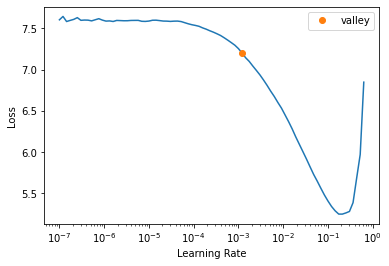

In [42]:
learn.lr_find()

In [43]:
learn.fine_tune(20, 0.01)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,5.427993,2.760610,0.508409,0.273426,1.692365,1.068245,00:27


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.792350,1.930792,0.338779,0.208073,1.079274,0.851519,00:31
1,2.274664,1.267292,0.263815,0.114849,0.819293,0.448000,00:31
2,1.830127,0.842876,0.188852,0.073042,0.592190,0.250686,00:32
3,1.462955,0.625289,0.142239,0.049015,0.445932,0.179357,00:31
4,1.189017,0.502174,0.112446,0.043248,0.362558,0.139617,00:31
5,0.968015,0.407751,0.093224,0.037001,0.282074,0.125677,00:31
6,0.789473,0.352119,0.076886,0.027391,0.242616,0.109504,00:32
7,0.651571,0.323078,0.068236,0.024507,0.230803,0.092274,00:33
8,0.537516,0.304248,0.063431,0.025469,0.199379,0.104868,00:32
9,0.444250,0.290773,0.056704,0.021144,0.204577,0.086195,00:32


After 20 epochs, it is better than training normally.

What would happen if we add progressive sizing?